## Imports

In [127]:
#Commonted out the below lines as the packages are already installed in the environment

# !pip install timm
# !pip install nibabel
# !pip install nilearn
# !pip install light-the-torch && ltt install torch
# !pip install torchio

import tensorflow as tf
#for neuroimaging data
import nibabel as nib
import nilearn as nilearn
import timm as timm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os
import torchio as tio



In [128]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is not available.


In [129]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name()} for inference' if torch.cuda.is_available() else 'Using CPU for inference')

Using CPU for inference


## Dataset 

In [135]:


root_dir = 'Dataset'
root_label_dir = 'Labels'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]
labelsubdirectories = [x[0] for x in os.walk(root_label_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    mri=tio.ScalarImage(file_path),
                    
                )
                dataset.append(subject)
        label_files = os.listdir(subdir.replace('Dataset', 'Labels'))
        for label_file in label_files:
                file_path = os.path.join(subdir.replace('Dataset', 'Labels'), label_file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    label=tio.LabelMap(file_path),
                )
       

# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))


FileNotFoundError: [Errno 2] No such file or directory: 'Labels/Peking_3/sub-4048810/ses-1/anat'

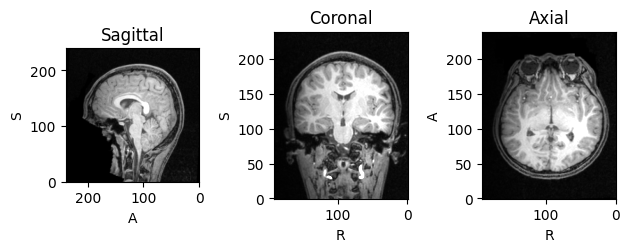

Image Shape: (1, 192, 240, 240)
Image Intensity: tensor(-1.6031)


In [131]:
transforms = [
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomAffine(),
    tio.RandomBiasField(),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.Resample(1),
]
transform = tio.Compose(transforms)
subjects_dataset = tio.SubjectsDataset(dataset, transform=transform)
subject = subjects_dataset[0]


# Get the first image from the subject
image = subject['mri']

# Plot the image
image.plot()
plt.show()

# Display the image shape
print('Image Shape: ' + str(image.shape))
# Display the image intensity
print('Image Intensity: ' + str(image.data.mean()))


## Modelling

In [132]:
import torch
import torchvision.models as models

# Load the pre-trained 3D CNN model
model = models.video.r3d_18(pretrained=True)

# Set the model to evaluation mode
model.eval()

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the model architecture
print(model)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [133]:
import torch
from torch.utils.data import DataLoader

# Create a data loader for the dataset
batch_size = 16
data_loader = DataLoader(subjects_dataset, batch_size=batch_size)

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predictions and labels
predictions = []
labels = []

# Iterate over the data loader
for batch in data_loader:
    # Get the inputs and labels from the batch
    inputs = batch['mri']
    target = batch['label']
    
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    target = target.to(device)
    
    # Forward pass through the model
    outputs = model(inputs)
    
    # Get the predicted class probabilities
    probabilities = torch.softmax(outputs, dim=1)
    
    # Get the predicted class labels
    _, predicted_labels = torch.max(probabilities, dim=1)
    
    # Append the predicted labels and target labels to the lists
    predictions.extend(predicted_labels.tolist())
    labels.extend(target.tolist())

# Convert the predictions and labels to tensors
predictions = torch.tensor(predictions)
labels = torch.tensor(labels)

# Calculate the accuracy
accuracy = torch.sum(predictions == labels).item() / len(labels)

# Print the accuracy
print(f"Accuracy: {accuracy}")

RuntimeError: stack expects each tensor to be equal size, but got [1, 192, 240, 240] at entry 0 and [1, 176, 256, 256] at entry 3